### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [6]:

import requests
from pathlib import Path

# URLs to download
urls = [
    "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz",
    "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz"
]

# Download and save files
for url in urls:
    filename = Path(url).name
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"Downloaded {filename}")

# Unzip files
import gzip
import shutil

for filename in ["GCF_000355675.1_ASM35567v1_genomic.fna.gz", "GCF_000355675.1_ASM35567v1_genomic.gbff.gz"]:
    with gzip.open(filename, 'rb') as f_in:
        with open(filename[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Unzipped {filename}")


Downloaded GCF_000355675.1_ASM35567v1_genomic.fna.gz
Downloaded GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Unzipped GCF_000355675.1_ASM35567v1_genomic.fna.gz
Unzipped GCF_000355675.1_ASM35567v1_genomic.gbff.gz


### Reading sequences

In [7]:
# Required library 'bio' should be pre-installed in the environment to avoid redundant installation steps
!pip install biopython

In [8]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("./GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('./GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [9]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [10]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'),
      seq.count('A'), seq.count('G')
    ]) / len(seq)


def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)


def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T,
                       index=['T', 'C', 'A', 'G'],
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [11]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181143,0.296068,0.315043,0.273024
C,0.206706,0.227065,0.233173,0.228923
A,0.256916,0.302111,0.238480,0.276478
G,0.355236,0.174755,0.213304,0.221574


### Transition probabilities

In [12]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3],
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1

    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5),
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [13]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185482,0.497862,0.316308,0.318271
C|T,0.189688,0.199483,0.179891,0.208911
A|T,0.249131,0.172440,0.221458,0.243934
G|T,0.375698,0.130215,0.282343,0.228884
T|C,0.185235,0.248571,0.269872,0.252402
C|C,0.156213,0.197930,0.244217,0.214059
A|C,0.276197,0.315174,0.244461,0.286765
G|C,0.382355,0.238325,0.241449,0.246775
T|A,0.179889,0.334011,0.307774,0.270128
C|A,0.194131,0.213909,0.193560,0.205302


TATTACTTC

In [14]:
P_seq_nc = t1['nc']['T']   * t2['nc']['A|T'] * t2['nc']['T|A'] * \
           t2['nc']['T|T'] * t2['nc']['A|T'] * t2['nc']['C|A'] * \
           t2['nc']['T|C'] * t2['nc']['T|T'] * t2['nc']['C|T']
P_seq_nc

4.812341505624151e-06

In [15]:
P_seq_cod = t1['pos1']['T']   * t2['pos2']['A|T'] * t2['pos3']['T|A'] * \
            t2['pos1']['T|T'] * t2['pos2']['A|T'] * t2['pos3']['C|A'] * \
            t2['pos1']['T|C'] * t2['pos2']['T|T'] * t2['pos3']['C|T']
P_seq_cod

9.873955022651802e-07

In [16]:
P_nc = 0.5
P_cod = 0.5
P_nc_seq = P_nc * P_seq_nc / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_nc_seq

0.8297516765118772

In [17]:
P_cod_seq = P_cod * P_seq_cod / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_cod_seq

0.17024832348812277

In [18]:
P_seq_cod2 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod2

4.4125895605963545e-06

### Prediction

In [19]:
def cod_proba(seq, t1, t2):
    frames = [1, 2, 3, 'nc']
    p_seq = {
        1 : t1['pos1'][seq[0]],
        2 : t1['pos2'][seq[0]],
        3 : t1['pos3'][seq[0]],
        'nc' : t1['nc'][seq[0]]
    }
    p_seq_pos = {
        1 : 0,
        2 : 1,
        3 : 2
    }

    for frame in frames:
        if frame != 'nc':
            for i in range(1, len(seq)):
                p_seq_pos[frame] = (p_seq_pos[frame] + 1) % 3
                p_seq[frame] *= t2[f'pos{p_seq_pos[frame]+1}'][f'{seq[i]}|{seq[i-1]}']
        else:       # non-coding
            for i in range(1, len(seq)):
                p_seq[frame] *= t2['nc'][f'{seq[i]}|{seq[i-1]}']

    s = sum(p_seq.values())
    return {frame: p_seq[frame]/s for frame in frames}

In [20]:
cod_proba("TATTACTTCACTGGA", t1, t2)

{1: 0.04440753163494479,
 2: 0.06779534127092735,
 3: 0.5619534871817272,
 'nc': 0.3258436399124006}

In [21]:
!pip install tqdm

In [22]:
from tqdm import tqdm

In [23]:
def cod_proba96(seq, t1, t2, start=0):
    probas = []
    for i in tqdm(range(0, len(seq)-95, 12)):
        res = cod_proba(seq[i:i+96], t1, t2)
        res['start'] = start + i
        probas.append(res)
    return probas

In [24]:
subseq_start = 0
subseq = seq[subseq_start:subseq_start+3000]
results = pd.DataFrame(cod_proba96(subseq, t1, t2, start=subseq_start))
results

100%|██████████| 243/243 [00:00<00:00, 575.28it/s]


,1,2,3,nc,start
0,8.376994e-01,2.712940e-06,0.017524,0.144774,0
1,5.777945e-01,8.803574e-07,0.268391,0.153813,12
2,3.039754e-01,7.482776e-06,0.446830,0.249187,24
3,3.379620e-01,2.723289e-04,0.179738,0.482028,36
4,3.503179e-01,5.068047e-04,0.059086,0.590089,48
...,...,...,...,...,...
238,2.902849e-07,1.519720e-06,0.997891,0.002108,2856
239,3.428920e-08,5.690443e-07,0.999346,0.000654,2868
240,1.170353e-06,6.348956e-07,0.998803,0.001196,2880
241,1.364785e-08,1.278968e-06,0.999411,0.000588,2892


In [25]:
from Bio.Data import CodonTable
import re

In [ ]:
def find_orfs_with_trans(seq, trans_table=11, min_protein_length=50):
    # taken from http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec384
    answer = []
    seq_len = len(seq)
    for strand, nuc in [(+1, seq), (-1, seq.reverse_complement())]:
        # for frame in range(3):
        frame = 0
        trans = nuc[frame:].translate(trans_table)
        trans_len = len(trans)
        aa_start = 0
        aa_end = 0
        while aa_start < trans_len:
            aa_end = trans.find("*", aa_start)
            if aa_end == -1:
                aa_end = trans_len
            if aa_end - aa_start >= min_protein_length:
                if strand == 1:
                    start = frame + aa_start * 3
                    end = min(seq_len, frame + aa_end * 3 + 3)
                else:
                    start = seq_len - frame - aa_end * 3 - 3
                    end = seq_len - frame - aa_start * 3
                answer.append((start, end, strand, trans[aa_start:aa_end]))
            aa_start = aa_end + 1
    answer.sort()
    return answer

def find_codons(seq):
    table = CodonTable.unambiguous_dna_by_id[11]
    ans = {'start': [], 'stop': []}
    for k, v in zip(('start', 'stop'), (table.start_codons, table.stop_codons)):
        for codon in v:
            for idx in range(0, len(seq), 3):
                if seq[idx:idx+3] == codon:
                    ans[k].append(idx)
    return {k: list(sorted(v)) for k, v, in ans.items()}

In [28]:
seq[0:30]

Seq('TTGGGTAGAATGGCTGGCTCGATTGAAATC')

In [29]:
print(CodonTable.unambiguous_dna_by_id[11])

Table 11 Bacterial, Archaeal, Plant Plastid

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I(s)| ACT T   | AAT N   | AGT S   | T
A | ATC I(s)| ACC T   | AAC N   | AGC S   | C
A | ATA I(s)| ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V(s)| GCG A   | GAG E   | GGG

/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


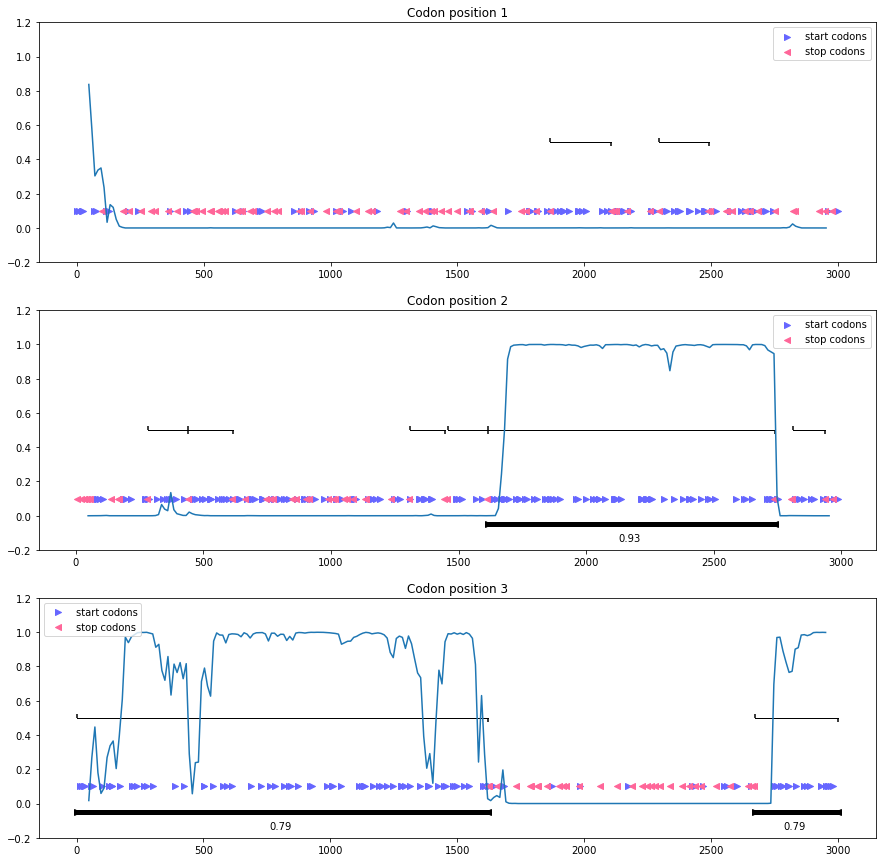

In [ ]:
def plot_graph():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    for i, ax in enumerate((ax1, ax2, ax3)):
        j = {0:0, 1:2, 2: 1}[i]
        
        for (start, stop, _, __) in filter(lambda x: x[2] == 1, find_orfs_with_trans(subseq[j:], min_protein_length=40)):
            ax.plot([start, stop], [.5, .5], color='#000', linewidth=1)
            ax.scatter([start], [.5], marker=2, color='#000', s=20)
            ax.scatter([stop], [.5], marker=3, color='#000', s=20)
            if results[i+1][(start // 12):(stop // 12 + 1)].mean() > 0.3:
                color = '#000'
            else:
                continue
            ax.plot([start], [-.05], marker=">" , color=color)
            ax.plot([stop], [-.05], marker="<", color=color)
            ax.plot([start, stop], [-.05, -.05], color=color, linewidth=5)
            ax.text((start + stop) / 2 - 50, -.15, f"{results[i+1][(start // 12):((stop // 12) + 1)].mean():.2f}", color=color)

        # plot all start and stop codons
        codons = find_codons(subseq[j:])
        ax.scatter(codons['start'], [.1 for k in codons['start']], marker=">" , color='#66f', label='start codons')
        ax.scatter(codons['stop'], [.1 for k in codons['stop']], marker="<" , color='#f69', label='stop codons')


        # plot probability values
        ax.plot(results['start'] + 48, results[i+1])
        ax.set_title(f'Codon position {i+1}')
        ax.set_ylim((-0.2, 1.2))
        ax.legend()
        # break

    plt.plot()
plot_graph()

### Бонус 1

In [31]:
def cod_proba_reverse(seq, t1, t2):
    frames = [1, 2, 3, 'nc']
    p_seq = {
        1 : t1['pos1'][seq[0]],
        2 : t1['pos2'][seq[0]],
        3 : t1['pos3'][seq[0]],
        'nc' : t1['nc'][seq[0]]
    }
    p_seq_pos = {
        1 : 0,
        2 : 1,
        3 : 2
    }

    for frame in frames:
        if frame != 'nc':
            for i in range(1, len(seq)):
                p_seq_pos[frame] = (p_seq_pos[frame] + 1) % 3
                p_seq[frame] *= t2[f'pos{p_seq_pos[frame]+1}'][f'{seq[i]}|{seq[i-1]}']
        else:       # non-coding
            for i in range(1, len(seq)):
                p_seq[frame] *= t2['nc'][f'{seq[i]}|{seq[i-1]}']


    # and now reverse
    seq_reverse = seq.reverse_complement()
    # print(f"Seq reverse is {str(seq_reverse)}")
    frames_reverse = [-1, -2, -3]
    p_seq_reverse = {
        -1 : t1['pos1'][seq[0]],
        -2 : t1['pos2'][seq[0]],
        -3 : t1['pos3'][seq[0]]
    }
    p_seq_pos_reverse = {
        -1 : 0,
        -2 : 1,
        -3 : 2
    }

    for frame in frames_reverse:
        for i in range(1, len(seq_reverse)):
            p_seq_pos_reverse[frame] = (p_seq_pos_reverse[frame] + 1) % 3
            p_seq_reverse[frame] *= t2[f'pos{p_seq_pos_reverse[frame]+1}'][f'{seq_reverse[i]}|{seq_reverse[i-1]}']

    p_seq_resulting = {**p_seq, **p_seq_reverse}
    s = sum(p_seq_resulting.values())
    frames_resulting = frames + frames_reverse

    return {frame: p_seq_resulting[frame]/s for frame in frames_resulting}

def cod_proba96_reverse(seq, t1, t2, start=0):
    probas = []
    for i in tqdm(range(0, len(seq)-95, 12)):
        res = cod_proba_reverse(seq[i:i+96], t1, t2)
        res['start'] = start + i
        res['end'] = start + 96 + i
        probas.append(res)
    return probas

def find_codons_reverse(seq, reverse=False, j=0):
    if not reverse:
        return find_codons(seq)
    else:
        revs = find_codons(seq.reverse_complement()[j:])
        for i in ('start', 'stop'):
            revs[i] = [len(seq) - j for j in revs[i]]
        return revs

def find_orfs_with_trans_reverse(seq, min_protein_length=50, reverse=False, j=0):
    if not reverse:
        return find_orfs_with_trans(seq[j:], min_protein_length=min_protein_length)
    else:
        revs = find_orfs_with_trans(seq.reverse_complement()[j:], min_protein_length=min_protein_length)
        # start, end, i, j
        result = []
        for (start, end, i, j) in revs:
            result.append([len(seq) - start, len(seq) - end, i, j])
        return result

100%|██████████| 243/243 [00:00<00:00, 320.88it/s]
/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before transla

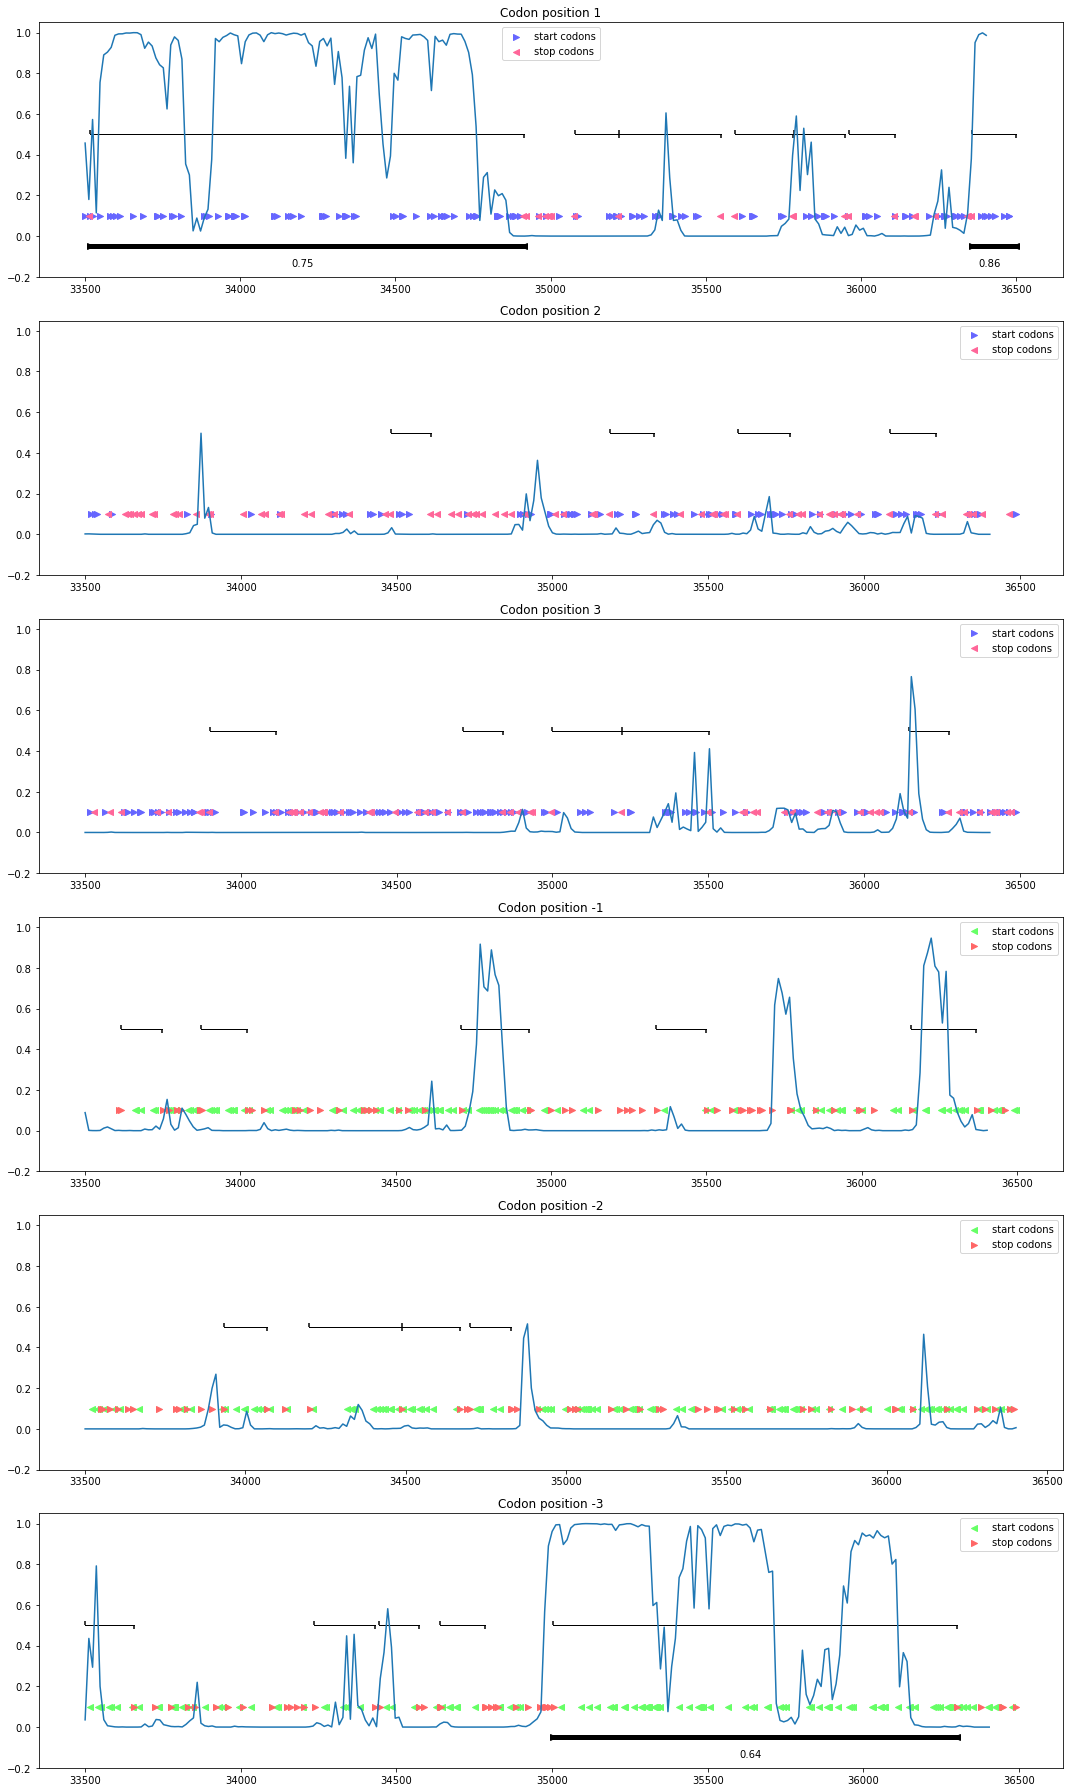

In [32]:
def plot_graph():
    subseq_start = 33500
    subseq = seq[subseq_start:subseq_start+3000]
    results = pd.DataFrame(cod_proba96_reverse(subseq, t1, t2, start=subseq_start))

    fig, axs = plt.subplots(6, 1, figsize=(15, 25))
    for i, ax in zip((1, 2, 3, -1, -2, -3), axs):
        IS_REVERSE = i < 0

        j = {1:0, 2:2, 3: 1, -1: 0, -2:2, -3:1 }[i]

        # plot ORFs with probabilities
        for (start, stop, _, __) in filter(lambda x: x[2] == 1, find_orfs_with_trans_reverse(subseq, min_protein_length=40, reverse=IS_REVERSE, j=j)):
            if stop < start:
                start, stop = stop, start
            ax.plot([start + subseq_start, stop + subseq_start], [.5, .5], color='#000', linewidth=1)
            ax.scatter([start + subseq_start], [.5], marker=2, color='#000', s=20)
            ax.scatter([stop + subseq_start], [.5], marker=3, color='#000', s=20)
            if results[i][(start // 12):(stop // 12 + 1)].mean() > 0.5:
                color = '#000'
            else:
                continue
                # color = '#ccc'
            ax.plot([start + subseq_start], [-.05], marker=">" , color=color)
            ax.plot([stop + subseq_start], [-.05], marker="<", color=color)
            ax.plot([start + subseq_start, stop + subseq_start], [-.05, -.05], color=color, linewidth=5)
            # if color == '#ccc' and i == -1:
            #     print(results[i])
            #     print(start, stop, "start stop")
            #     print(results[i][(start // 12):((stop // 12) + 1)])
            #     return
            ax.text((start + stop) / 2 - 50  + subseq_start, -.15, f"{results[i][(start // 12):((stop // 12) + 1)].mean():.2f}", color=color)

        # plot all start and stop codons
        start_color = '#6f6' if IS_REVERSE else '#66f'
        stop_color = '#f66' if IS_REVERSE else '#f69'
        start_marker = '<' if IS_REVERSE else '>'
        stop_marker = '>' if IS_REVERSE else '<'
        codons = find_codons_reverse(subseq[j:], reverse=IS_REVERSE, j=j)
        ax.scatter([k + subseq_start for k in codons['start']], [.1 for k in codons['start']], marker=start_marker, color=start_color, label='start codons')
        ax.scatter([k + subseq_start for k in codons['stop']], [.1 for k in codons['stop']], marker=stop_marker, color=stop_color, label='stop codons')


        # plot probability values
        ax.plot(results['start'], results[i])
        ax.set_title(f'Codon position {i}')
        ax.set_ylim((-0.2, 1.05))
        ax.legend()
        # break

    plt.tight_layout()
    plt.plot()
plot_graph()

# Бонус 2

In [35]:
FNAME = "./GCF_000355675.1_ASM35567v1_genomic.fna"

In [36]:
def find_orfs_with_trans_framewise(seq, trans_table=11, min_protein_length=50):
    # taken from http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec384
    answer = []
    seq_len = len(seq)
    for strand, nuc in [(+1, seq), (-1, seq.reverse_complement())]:
        for frame in range(3):
            trans = nuc[frame:].translate(trans_table)
            trans_len = len(trans)
            aa_start = 0
            aa_end = 0
            while aa_start < trans_len:
                aa_end = trans.find("*", aa_start)
                if aa_end == -1:
                    aa_end = trans_len
                if aa_end - aa_start >= min_protein_length:
                    if strand == 1:
                        start = frame + aa_start * 3
                        end = min(seq_len, frame + aa_end * 3 + 3)
                    else:
                        start = seq_len - frame - aa_end * 3 - 3
                        end = seq_len - frame - aa_start * 3
                    answer.append((start, end, strand, trans[aa_start:aa_end]))
                aa_start = aa_end + 1
    answer.sort()
    return answer

coding_total = []
noncoding_total = []
for record in SeqIO.parse(FNAME, "fasta"):
    seq = record.seq
    l = len(seq)
    all_frames = find_orfs_with_trans_framewise(seq[:l], min_protein_length=90)
    mask = [False for _ in range(l)]
    print(len(all_frames))
    for (start, end, _, __) in all_frames:
        if (end - start) / l < 0.5:
            mask[start:end+1] = [True for _ in range(end - start + 1)]
    coding = ['']
    noncoding = ['']
    for i, val in enumerate(mask):
        if i == 0:
            if val:
                coding[0] = seq[i]
            else:
                noncoding[0] = seq[i]
        if mask[i-1] != mask[i]:
            if mask[i]:
                coding.append(seq[i])
            else:
                noncoding.append(seq[i])
        else:
            if mask[i]:
                coding[-1] += seq[i]
            else:
                noncoding[-1] += seq[i]
    if len(coding[0]) == 0:
        coding.pop(0)
    if len(noncoding[0]) == 0:
        noncoding.pop(0)
    print(len(coding), len(noncoding))
    f = lambda x: len(x) > 10
    coding = list(filter(f, coding))
    noncoding = list(filter(f, noncoding))
    # print(''.join(['*' if i else ' ' for i in mask[1000:9000]]))
    coding_total.extend(coding)
    noncoding_total.extend(noncoding)

t1_denovo = make_table1(coding_total, noncoding_total)
t1_denovo

/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


6586
1928 1929


,pos1,pos2,pos3,nc
T,0.264782,0.264684,0.262868,0.287269
C,0.235645,0.237914,0.234103,0.213851
A,0.267186,0.265299,0.267245,0.289896
G,0.232387,0.232103,0.235783,0.208985


In [ ]:
t2_denovo = make_table2(coding_total, noncoding_total)
t2_denovo

,pos1,pos2,pos3,nc
T|T,0.263545,0.363608,0.303864,0.330650
C|T,0.199495,0.178486,0.257386,0.189663
A|T,0.253860,0.227220,0.191332,0.270957
G|T,0.283101,0.230686,0.247417,0.208730
T|C,0.225413,0.234561,0.229907,0.280102
C|C,0.184139,0.185664,0.255409,0.209727
A|C,0.306416,0.319656,0.248708,0.287367
G|C,0.284031,0.260119,0.265976,0.222805
T|A,0.249716,0.290642,0.285903,0.267203
C|A,0.205862,0.210961,0.214907,0.190800


100%|██████████| 243/243 [00:02<00:00, 86.17it/s] 
/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:2983: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:2983: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:2983: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:2983: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. T

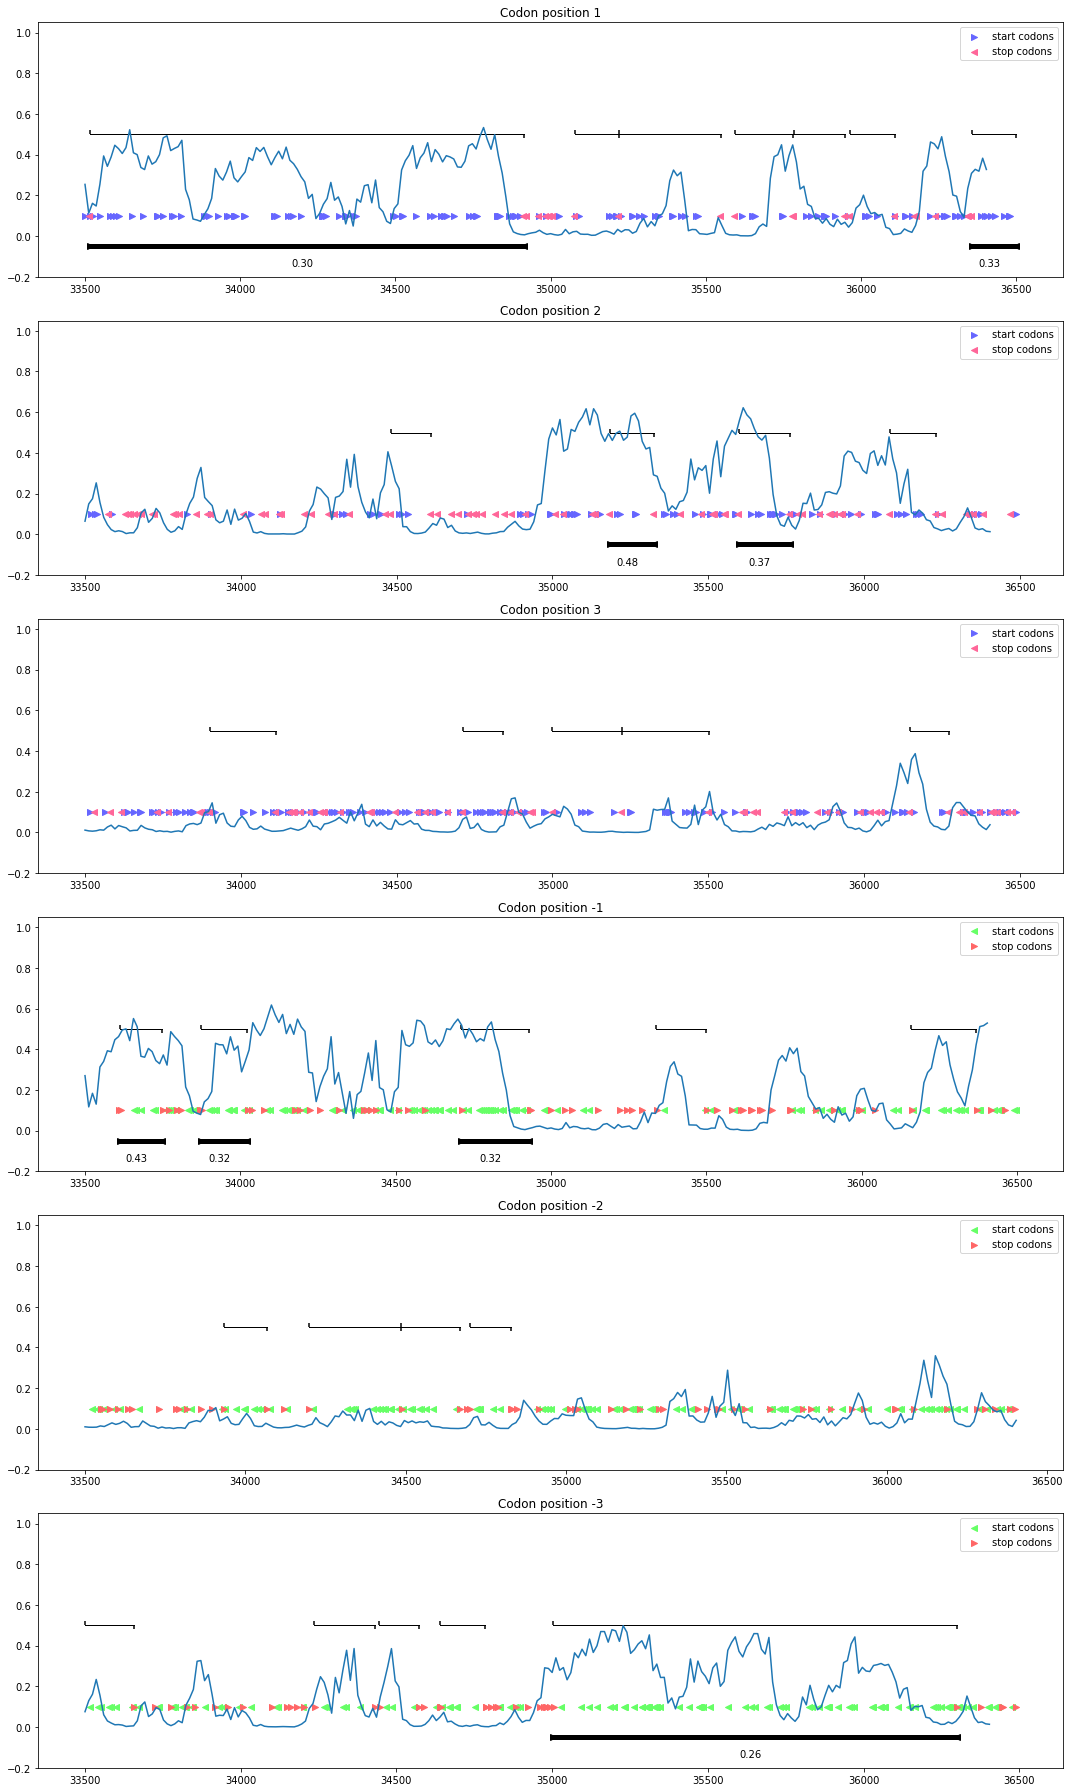

In [ ]:
def plot_graph(seq, t1, t2, subseq_start=33500):
    subseq_start = 33500
    subseq = seq[subseq_start:subseq_start+3000]
    results = pd.DataFrame(cod_proba96_reverse(subseq, t1, t2, start=subseq_start))

    fig, axs = plt.subplots(6, 1, figsize=(15, 25))
    for i, ax in zip((1, 2, 3, -1, -2, -3), axs):
        IS_REVERSE = i < 0

        j = {1:0, 2:2, 3: 1, -1: 0, -2:2, -3:1 }[i]

        # plot ORFs with probabilities
        for (start, stop, _, __) in filter(lambda x: x[2] == 1, find_orfs_with_trans_reverse(subseq, min_protein_length=40, reverse=IS_REVERSE, j=j)):
            if stop < start:
                start, stop = stop, start
            ax.plot([start + subseq_start, stop + subseq_start], [.5, .5], color='#000', linewidth=1)
            ax.scatter([start + subseq_start], [.5], marker=2, color='#000', s=20)
            ax.scatter([stop + subseq_start], [.5], marker=3, color='#000', s=20)
            if results[i][(start // 12):(stop // 12 + 1)].mean() > 0.25:
                color = '#000'
            else:
                continue
                # color = '#ccc'
            ax.plot([start + subseq_start], [-.05], marker=">" , color=color)
            ax.plot([stop + subseq_start], [-.05], marker="<", color=color)
            ax.plot([start + subseq_start, stop + subseq_start], [-.05, -.05], color=color, linewidth=5)
            # if color == '#ccc' and i == -1:
            #     print(results[i])
            #     print(start, stop, "start stop")
            #     print(results[i][(start // 12):((stop // 12) + 1)])
            #     return
            ax.text((start + stop) / 2 - 50  + subseq_start, -.15, f"{results[i][(start // 12):((stop // 12) + 1)].mean():.2f}", color=color)

        # plot all start and stop codons
        start_color = '#6f6' if IS_REVERSE else '#66f'
        stop_color = '#f66' if IS_REVERSE else '#f69'
        start_marker = '<' if IS_REVERSE else '>'
        stop_marker = '>' if IS_REVERSE else '<'
        codons = find_codons_reverse(subseq[j:], reverse=IS_REVERSE, j=j)
        ax.scatter([k + subseq_start for k in codons['start']], [.1 for k in codons['start']], marker=start_marker, color=start_color, label='start codons')
        ax.scatter([k + subseq_start for k in codons['stop']], [.1 for k in codons['stop']], marker=stop_marker, color=stop_color, label='stop codons')


        # plot probability values
        ax.plot(results['start'], results[i])
        ax.set_title(f'Codon position {i}')
        ax.set_ylim((-0.2, 1.05))
        ax.legend()
        # break

    plt.tight_layout()
    plt.plot()
plot_graph(seq, t1_denovo, t2_denovo)